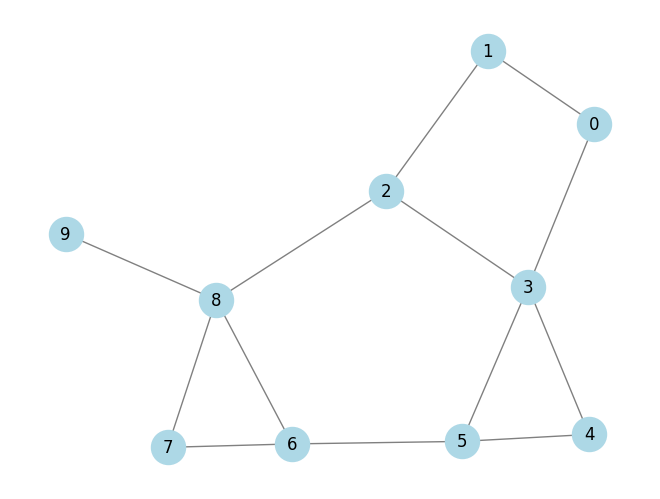

In [73]:
from mimiqcircuits import *
import networkx as nx

n = 10

edges = [(0, 1), (0, 3), (1, 2), (2, 3), (2, 8),(3, 4), (4, 5), (3, 5), (5, 6), (6, 7), (6, 8), (7, 8), (8, 9)]

G = nx.Graph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=600)

QUBO formalization : 

In [110]:
def ansatz_circuit(gamma, beta):
    c = Circuit()
    c.push(GateH(),range(n))

    c.push(GateRZ(2*gamma), range(n))
    
    for j, k in edges:
        c.push(GateRZZ(gamma), j, k)
    
    c.push(GateRX(2*beta), range(n))

    return c

In [115]:
def QAOA_circuit(gamma, beta, layer):
    c = Circuit()
    for i in range(layer):

        c.append(ansatz_circuit(gamma, beta))
    return c 


Connection

In [116]:
# Connection
conn = MimiqConnection(url = QPERFECT_CLOUD)
conn.connect("fweili@protonmail.com", "iosh3iem7Veo")


Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 1160/3000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [117]:
n_shots = 1500
def cost_function(params):
    layer = 2
    gamma, beta = params
    j_id = conn.execute(QAOA_circuit(gamma, beta, layer), nsamples=n_shots)
    while True:
        if conn.isJobDone(j_id):
            break
    res = conn.get_result(j_id)
    expectation = 0
    for bs in res.cstates:
        for i, j in edges:
            expectation += 1 if bs[i] == bs[j] else -1
    return expectation/n_shots

In [119]:
from scipy.optimize import minimize
import numpy as np
initial_params = [np.pi/4, np.pi/4]
result = minimize(cost_function, initial_params, method="COBYLA")
optimal_gamma, optimal_beta = result.x

In [120]:
final_circ = ansatz_circuit(optimal_gamma, optimal_beta)
final_circ.draw()

        ┌─┐                           ┌─────────────────────┐                   
 q[0]: ╶┤H├───────────────────────────┤RZ(4.064569109666098)├──────────────────╴
        └─┘┌─┐                        └─────────────────────┘                   
 q[1]: ╶───┤H├─────────────────────────────────────────────────────────────────╴
           └─┘┌─┐                                                               
 q[2]: ╶──────┤H├──────────────────────────────────────────────────────────────╴
              └─┘┌─┐                                                            
 q[3]: ╶─────────┤H├───────────────────────────────────────────────────────────╴
                 └─┘┌─┐                                                         
 q[4]: ╶────────────┤H├────────────────────────────────────────────────────────╴
                    └─┘┌─┐                                                      
 q[5]: ╶───────────────┤H├─────────────────────────────────────────────────────╴
                       └─┘┌─

In [121]:
j_id = conn.execute(final_circ, nsamples=4096)
while True:
    if conn.isJobDone(j_id):
        break
res = conn.get_result(j_id)
res

QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── parse time: 0.000208787s
│    ├── apply time: 0.000935429s
│    ├── total time: 0.001801469s
│    ├── compression time: 0.000150629s
│    └── sample time: 0.000425535s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"1101100110" => 86
│    ├── bs"1000100110" => 43
│    ├── bs"0010100110" => 42
│    ├── bs"1101010110" => 40
│    └── bs"1101111110" => 35
├── 1 executions
├── 0 amplitudes
└── 4096 samples

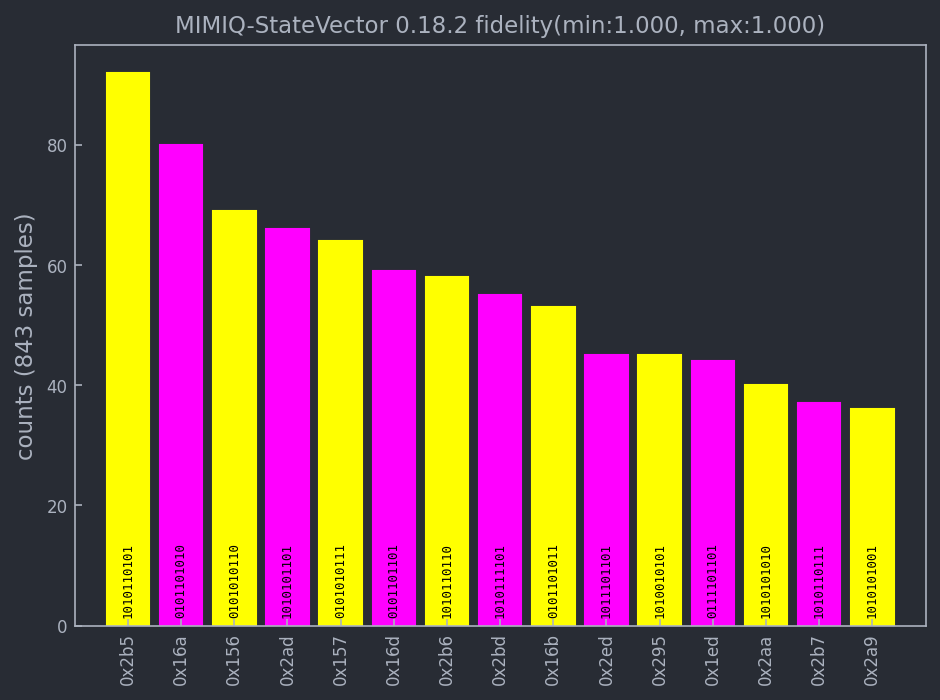

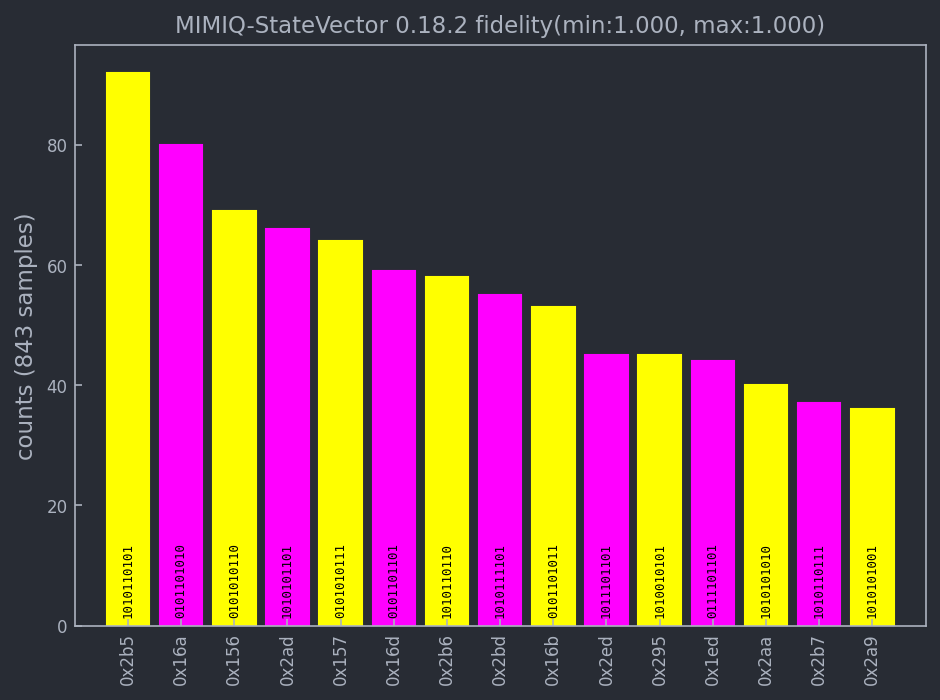

In [81]:
from mimiqcircuits.visualization import plothistogram
plothistogram(res)